# 文本挖掘
1.请针对已收集的文档通过与查询 Q1 匹配，进行匹配排序。请考虑文档的长度和停词等因素： \
Q1=“水上赛事因天气因素被中断” 

2.请与 Q2=“ 水上赛事因风力级别过高被 中断 的词频分布比较，最为匹配的是哪些文档。

In [1]:
#导入所需库
import jieba.posseg as pseg
import codecs
import os
from gensim import corpora,models,similarities

In [2]:
#设置工作环境
os.chdir("D:\\研究生课程\\机器学习方法与基础\\文本分析\\全部文件")
#获取所有的文本文件
filenames = os.listdir()

#构建停用词表
#来源：https://github.com/goto456/stopwords
stop_words = "D:\\研究生课程\\机器学习方法与基础\\文本分析\\baidu_stopwords.txt"
stopwords = codecs.open(stop_words,'r',encoding='utf-8').readlines()
stopwords = [w.strip() for w in stopwords]

#结巴分词后的停用词词性 [标点符号、连词、助词、副词、介词、时语素、‘的’、数词、方位词、代词]
stop_flag = ['x', 'c', 'u','d', 'p', 't', 'uj', 'm', 'f', 'r']

In [3]:
#对一篇文章进行分词、去停用词
def tokenization(filename):
    result = []
    with open(filename, 'r',encoding= 'utf-8') as f:
        text = f.read()
        words = pseg.cut(text)
    for word, flag in words:
        if flag not in stop_flag and word not in stopwords:
            result.append(word)
    return result
#得到语料库corpus
corpus = []
for each in filenames:
    corpus.append(tokenization(each))
#得到74份语料库
print(len(corpus))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ZHOU'L~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.565 seconds.
Prefix dict has been built successfully.


71


In [4]:
#建立词袋模型，就是把所有的语料库都用向量表示
dictionary = corpora.Dictionary(corpus)
print(dictionary)

doc_vectors = [dictionary.doc2bow(text) for text in corpus]
print(len(doc_vectors))
#print(doc_vectors)

Dictionary(4820 unique tokens: ['cn', 'http', 'sina', 'www', '世界']...)
71


## TF-IDF模型 
词袋模型简单易懂，但是存在问题。中文文本里最常见的词是“的”、“是”、“有”这样的没有实际含义的词。一篇关于足球的中文文本，“的”出现的数量肯定多于“足球”。所以，要对文本中出现的词赋予权重。
一个词的权重由TF * IDF 表示，其中TF表示词频，即一个词在这篇文本中出现的频率；IDF表示逆文档频率，即一个词在所有文本中出现的频率倒数。因此，一个词在某文本中出现的越多，在其他文本中出现的越少，则这个词能很好地反映这篇文本的内容，权重就越大。
回过头看词袋模型，只考虑了文本的词频，而TF-IDF模型则包含了词的权重，更加准确。文本向量与词袋模型中的维数相同，只是每个词的对应分量值换成了该词的TF-IDF值。
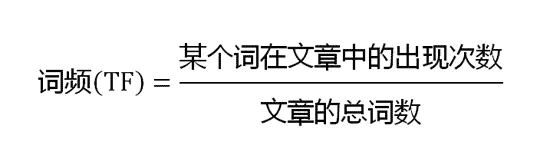
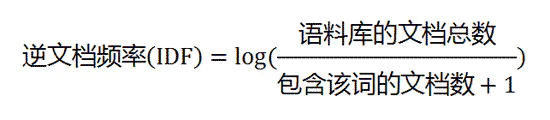

In [5]:
#TF-IDF模型计算文本相似度

#构建模型
tfidf = models.TfidfModel(doc_vectors)
tfidf_vectors = tfidf[doc_vectors]
#查看基本信息
print(len(tfidf_vectors))
print(len(tfidf_vectors[0]))

#输入查询
query = tokenization('..\\query1.txt')
query_bow = dictionary.doc2bow(query)
#查看 查询的基本信息
print(len(query_bow))
print(query_bow)

71
54
5
[(7, 1), (22, 1), (88, 1), (164, 1), (528, 1)]


In [6]:
query

['水上', '赛事', '天气', '因素', '中断']

In [7]:
#计算相似度
index = similarities.MatrixSimilarity(tfidf_vectors)
sims = index[query_bow]

In [9]:
#利用pandas.data.frame进行排序
from pandas.core.frame import DataFrame
sim_df = DataFrame(list(enumerate(sims)),columns = ['id','similarity'])
sim_df['text'] = filenames
sim_df.sort_values(by = ['similarity'],ascending = False)

,id,similarity,text
50,50,0.137284,text54.txt
66,66,0.079573,text69.txt
57,57,0.072279,text60.txt
43,43,0.065850,text48.txt
62,62,0.065850,text65.txt
...,...,...,...
9,9,0.001466,text17.txt
47,47,0.000000,text51.txt
7,7,0.000000,text15.txt
27,27,0.000000,text33.txt


可以查看相对应的语料库。结果显示similarity高的文档的语义与查询语义十分接近。

## 第二问
按题目要求可以构建TF-IDF模型进行分析

In [18]:
#输入查询
query = tokenization('..\\query2.txt')
query_bow = dictionary.doc2bow(query)
#查看 查询的基本信息
print(len(query_bow))
print(query_bow)

6
[(7, 1), (164, 1), (418, 1), (528, 1), (584, 1), (2580, 1)]


In [19]:
query

['水上', '赛事', '风力', '级别', '高', '中断']

In [20]:
#计算相似度
index = similarities.MatrixSimilarity(tfidf_vectors)
sims = index[query_bow]

In [21]:
#利用pandas.data.frame进行排序
from pandas.core.frame import DataFrame
sim_df = DataFrame(list(enumerate(sims)),columns = ['id','similarity'])
sim_df['text'] = filenames
sim_df.sort_values(by = ['similarity'],ascending = False)

,id,similarity,text
50,50,0.127973,text54.txt
35,35,0.068821,text40.txt
57,57,0.065982,text60.txt
66,66,0.063156,text69.txt
49,49,0.061929,text53.txt
...,...,...,...
33,33,0.000000,text39.txt
30,30,0.000000,text36.txt
26,26,0.000000,text32.txt
16,16,0.000000,text23.txt


## 第二问
按题目要求可以构建LDA模型进行分析

In [10]:
#LDA模型
lda = models.LdaModel(doc_vectors,id2word=dictionary,num_topics=2)
lda_vector = lda[doc_vectors]
#查看基本情况
print(len(lda[doc_vectors]))
print(len(lda[doc_vectors][0]))

71
1


In [11]:
#设置查询
query2 = tokenization('..\\query2.txt')
query_bow2 = dictionary.doc2bow(query)
print(query_bow)
query2

[(7, 1), (22, 1), (88, 1), (164, 1), (528, 1)]


['水上', '赛事', '风力', '级别', '高', '中断']

In [12]:
#查询
query_lda = lda[query_bow2]
print(query_lda)

[(0, 0.88566816), (1, 0.1143318)]


In [13]:
#结果排序
index = similarities.MatrixSimilarity(lda_vector)
sims_lda = index[query_lda]
from pandas.core.frame import DataFrame
sim_lda_df = DataFrame(list(enumerate(sims_lda)),columns = ['id','similarity'])
sim_lda_df['text'] = filenames
sim_lda_df.sort_values(by = ['similarity'],ascending = False)

,id,similarity,text
46,46,0.999983,text50.txt
37,37,0.999947,text42.txt
41,41,0.999749,text46.txt
7,7,0.999673,text15.txt
68,68,0.997324,text70.txt
...,...,...,...
38,38,0.128029,text43.txt
23,23,0.128029,text3.txt
34,34,0.128029,text4.txt
33,33,0.128029,text39.txt


## 第二问
尝试构建LSA模型

In [14]:
#LSI计算文本相似度
#有三个空白文档
lsi = models.LsiModel(tfidf_vectors, id2word=dictionary, num_topics=2)
lsi.print_topics(2)
lsi_vector = lsi[tfidf_vectors]
for vec in lsi_vector:
    print(vec)
query3 = tokenization('..\\query2.txt')
query_bow3 = dictionary.doc2bow(query3)
print(query_bow3)
query_lsi = lsi[query_bow]
print(query_lsi)

[(0, 0.14906885492433478), (1, -0.2632353811683758)]
[(0, 0.21305369793199305), (1, -0.39983802186455597)]
[(0, 0.09271376288231875), (1, -0.06953656828392124)]
[(0, 0.3523417529073587), (1, -0.2081107872734699)]
[(0, 0.20288079663459282), (1, -0.2253138742854469)]
[(0, 0.11954204097366229), (1, -0.12020980520492917)]
[(0, 0.1510534225795525), (1, -0.1558955172677665)]
[(0, 0.1209506321554042), (1, -0.13386804465386584)]
[(0, 0.345355505293632), (1, -0.21291399582702003)]
[(0, 0.08126923189397747), (1, -0.08911587911409458)]
[(0, 0.1936718108245974), (1, -0.03640271821916495)]
[(0, 0.20275407681527804), (1, 0.0033366796560938307)]
[(0, 0.1397907728659292), (1, -0.11880654386137994)]
[(0, 0.15717253981314436), (1, -0.0715395065904189)]
[(0, 0.16600346520011697), (1, -0.07777586977473662)]
[(0, 0.13786247902937848), (1, -0.1312686530967535)]
[(0, 0.09916429404636697), (1, -0.08343835763501614)]
[(0, 0.31050669868870506), (1, 0.1654162538943124)]
[(0, 0.13749224813258842), (1, -0.11953362

In [15]:
query3

['水上', '赛事', '风力', '级别', '高', '中断']

In [16]:
index = similarities.MatrixSimilarity(lsi_vector)
sims = index[query_lsi]
from pandas.core.frame import DataFrame
sim_lsi_df = DataFrame(list(enumerate(sims)),columns = ['id','similarity'])
sim_lsi_df['text'] = filenames
sim_lsi_df.sort_values(by = ['similarity'],ascending = False)

,id,similarity,text
10,10,0.999718,text18.txt
31,31,0.998316,text37.txt
43,43,0.995442,text48.txt
62,62,0.995442,text65.txt
22,22,0.993903,text29.txt
...,...,...,...
1,1,0.643533,text1.txt
60,60,0.633894,text63.txt
39,39,0.633894,text44.txt
61,61,0.591411,text64.txt
